# **Modelo Auto_arima com variáveis exógenas - Séries Temporais**

###  Notebook: `03_06_C2_Modelo_Auto_Arima_com_exog`

## Modelo Auto-Arima com variáveis Exógenas

---
O modelo implementado a seguir mostra os resultados para o algoritmo SARIMAX, incluindo variáveis exógenas (preditores diversos do valor a ser analizado na série temporal).

___

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import math
import requests
import json
import os
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## 1. Importando os datasets

In [3]:
dataset_cluster2_series = pd.read_csv("datasets//dataset_cluster2_series.csv")
dataset_cluster2_validacao = pd.read_csv("datasets//dataset_cluster2_validation.csv")


dataset_cluster2_series = dataset_cluster2_series.append(dataset_cluster2_validacao, ignore_index=True)

### 1.1 Diferenciando as séries

---
Considerando os resultados do teste Phillips-Perron para raiz unitária, iremos diferenciar as séries de taxa de câmbio, taxa SELIC, TJLP, PIB mensal e Preço Brent, uma vez que as variáveis exógenas no modelo não pode ter tendência. Usarei o mesmo teste na elaboração do modelo

---

In [4]:
dataset_cluster2_series['cambio_diff'] = dataset_cluster2_series['taxa_cambio'].diff()
dataset_cluster2_series['selic_diff'] = dataset_cluster2_series['taxa_selic'].diff()
dataset_cluster2_series['tjlp_diff'] = dataset_cluster2_series['tjlp'].diff()
dataset_cluster2_series['pib_diff'] = dataset_cluster2_series['pib_mensal'].diff()
dataset_cluster2_series['brent_diff'] = dataset_cluster2_series['preco_brent'].diff()


In [5]:
dataset_cluster2_series = dataset_cluster2_series.dropna()

In [6]:
dataset_cluster2_series = dataset_cluster2_series.drop(['taxa_cambio',
                              'taxa_selic','tjlp','pib_mensal','preco_brent'], axis=1)

In [7]:
dataset_cluster2_series

,mes,indice_pimpf,ipca,ibcbr,desembolso,debitos,arrecadacao,cambio_diff,selic_diff,tjlp_diff,pib_diff,brent_diff
1,2004-02-01 00:00:00,103.1,0.61,99.45,2559.0,4.150874e+09,5.844144e+09,3.65,-0.02,0.00,11487.7,-0.31
2,2004-03-01 00:00:00,113.0,0.47,111.98,4302.0,3.778614e+09,5.757594e+09,-0.95,-0.11,0.00,18673.0,2.93
3,2004-04-01 00:00:00,107.8,0.37,107.36,5474.0,4.927327e+09,7.872113e+09,-0.04,-0.23,-0.25,15565.8,-0.44
4,2004-05-01 00:00:00,108.9,0.51,106.03,5976.0,2.175496e+09,7.156122e+09,9.40,-0.19,0.00,19893.1,4.56
5,2004-06-01 00:00:00,113.1,0.71,107.00,7338.0,2.078371e+09,7.048868e+09,0.79,0.03,0.00,27348.8,-2.73
...,...,...,...,...,...,...,...,...,...,...,...,...
199,2020-08-01 00:00:00,97.5,0.24,135.52,7081.0,1.898179e+10,2.206463e+10,5.20,-0.21,0.00,-507.3,1.45
200,2020-09-01 00:00:00,104.9,0.64,137.10,7525.0,1.518463e+10,2.362301e+10,-2.63,-0.04,0.00,18606.3,-3.17
201,2020-10-01 00:00:00,101.2,0.86,139.73,8319.0,2.685862e+10,3.264090e+10,5.09,0.00,-0.36,18786.6,-0.62
202,2020-11-01 00:00:00,104.1,0.89,138.11,9338.0,2.207857e+10,2.663530e+10,-6.62,0.00,0.00,31664.3,2.76


In [8]:
# Montado as séries de entrada (arrecadação e demais variáveis) e as séries de validação (arrecadação e demais variáveis)



serie_cluster2 = dataset_cluster2_series[:191].copy()
serie_cluster2_exog = dataset_cluster2_series[:191].copy()

validacao_cluster2 = dataset_cluster2_series[191:].copy()
validacao_cluster2_exog = dataset_cluster2_series[191:].copy()


serie_cluster2 = serie_cluster2.drop(['indice_pimpf', 'ipca', 'selic_diff', 'cambio_diff', 'ibcbr',
                                     'tjlp_diff','pib_diff','brent_diff','desembolso','debitos'], axis=1)
serie_cluster2_exog = serie_cluster2_exog.drop(['arrecadacao'], axis=1)

validacao_cluster2 = validacao_cluster2.drop(['indice_pimpf', 'ipca', 'selic_diff', 'cambio_diff', 'ibcbr',
                                     'tjlp_diff','pib_diff','brent_diff','desembolso','debitos'], axis=1)
validacao_cluster2_exog = validacao_cluster2_exog.drop(['arrecadacao'], axis=1)






In [9]:
serie_cluster2.tail()

,mes,arrecadacao
187,2019-08-01 00:00:00,2.611246e+10
188,2019-09-01 00:00:00,2.364670e+10
189,2019-10-01 00:00:00,3.041535e+10
190,2019-11-01 00:00:00,2.438107e+10
191,2019-12-01 00:00:00,2.676134e+10


In [10]:
serie_cluster2_exog.head()

,mes,indice_pimpf,ipca,ibcbr,desembolso,debitos,cambio_diff,selic_diff,tjlp_diff,pib_diff,brent_diff
1,2004-02-01 00:00:00,103.1,0.61,99.45,2559.0,4.150874e+09,3.65,-0.02,0.00,11487.7,-0.31
2,2004-03-01 00:00:00,113.0,0.47,111.98,4302.0,3.778614e+09,-0.95,-0.11,0.00,18673.0,2.93
3,2004-04-01 00:00:00,107.8,0.37,107.36,5474.0,4.927327e+09,-0.04,-0.23,-0.25,15565.8,-0.44
4,2004-05-01 00:00:00,108.9,0.51,106.03,5976.0,2.175496e+09,9.40,-0.19,0.00,19893.1,4.56
5,2004-06-01 00:00:00,113.1,0.71,107.00,7338.0,2.078371e+09,0.79,0.03,0.00,27348.8,-2.73


In [11]:
validacao_cluster2.tail()

,mes,arrecadacao
199,2020-08-01 00:00:00,2.206463e+10
200,2020-09-01 00:00:00,2.362301e+10
201,2020-10-01 00:00:00,3.264090e+10
202,2020-11-01 00:00:00,2.663530e+10
203,2020-12-01 00:00:00,2.910259e+10


In [12]:
validacao_cluster2_exog.head()

,mes,indice_pimpf,ipca,ibcbr,desembolso,debitos,cambio_diff,selic_diff,tjlp_diff,pib_diff,brent_diff
192,2020-01-01 00:00:00,101.5,0.21,133.60,257.0,2.095456e+10,1.22,-0.19,-0.48,28802.6,-2.25
193,2020-02-01 00:00:00,99.6,0.25,134.65,792.0,1.304137e+10,5.68,-0.21,0.00,28000.7,-8.60
194,2020-03-01 00:00:00,95.7,0.07,136.70,1294.0,1.587917e+10,14.68,-0.24,0.00,21426.2,-22.02
195,2020-04-01 00:00:00,68.2,-0.31,119.15,2254.0,1.198779e+10,11.45,-0.30,-0.15,-62378.6,-9.64
196,2020-05-01 00:00:00,76.2,-0.38,119.78,3078.0,5.769186e+09,9.53,-0.64,0.00,-57680.8,7.68


### 1.2 Normalizando a escala

In [13]:
## Modificando as escalas. Como os datasets possuem dimensões diferentes, serão criados 4 scalers separados


scaler_in = MinMaxScaler(feature_range=(0, 1))
scaler_in_exog = MinMaxScaler(feature_range=(0, 1))

scaler_valid = MinMaxScaler(feature_range=(0, 1))
scaler_valid_exog = MinMaxScaler(feature_range=(0, 1))

serie_cluster2 = pd.DataFrame(scaler_in.fit_transform(serie_cluster2[['arrecadacao']]))
serie_cluster2_exog = pd.DataFrame(scaler_in_exog.fit_transform(serie_cluster2_exog[['indice_pimpf', 'ipca', 
                                    'selic_diff', 'cambio_diff', 'ibcbr',
                                     'tjlp_diff','pib_diff','brent_diff','desembolso','debitos']]))

# Definindo um scaler específico para a validação


validacao_cluster2 = pd.DataFrame(scaler_valid.fit_transform(validacao_cluster2[['arrecadacao']]))
validacao_cluster2_exog = pd.DataFrame(scaler_valid_exog.fit_transform(validacao_cluster2_exog[['indice_pimpf', 'ipca', 
                                    'selic_diff', 'cambio_diff', 'ibcbr',
                                     'tjlp_diff','pib_diff','brent_diff','desembolso','debitos']]))

In [14]:
serie_cluster2.columns=['arrecadacao']
serie_cluster2_exog.columns=['indice_pimpf', 'ipca','ibcbr','desembolso','debitos',
                            'cambio_diff', 'selic_diff', 'tjlp_diff', 'pib_diff', 'brent_diff']
validacao_cluster2.columns=['arrecadacao']
validacao_cluster2_exog.columns=['indice_pimpf', 'ipca','ibcbr','desembolso','debitos',
                            'cambio_diff', 'selic_diff', 'tjlp_diff', 'pib_diff', 'brent_diff']
serie_cluster2_exog

,indice_pimpf,ipca,ibcbr,desembolso,debitos,cambio_diff,selic_diff,tjlp_diff,pib_diff,brent_diff
0,0.558659,0.541935,0.583333,0.548742,0.000000,0.629630,0.083449,0.648236,0.028092,0.204364
1,0.835196,0.451613,0.529762,0.367925,0.237851,0.629630,0.228142,0.729297,0.050771,0.185978
2,0.689944,0.387097,0.458333,0.403695,0.150152,0.444444,0.165571,0.644984,0.066020,0.242715
3,0.720670,0.477419,0.482143,0.774764,0.124905,0.629630,0.252711,0.770078,0.072552,0.106798
4,0.837989,0.606452,0.613095,0.436321,0.143318,0.629630,0.402849,0.587691,0.090274,0.102001
...,...,...,...,...,...,...,...,...,...,...
186,0.413408,0.219355,0.297619,0.669418,0.803531,0.629630,0.422665,0.537153,0.069625,0.796526
187,0.519553,0.122581,0.482143,0.523978,0.736712,0.629630,0.773648,0.733050,0.076378,0.690097
188,0.541899,0.212903,0.398810,0.372642,0.822893,0.348148,0.621267,0.581936,0.081686,0.874076
189,0.455307,0.477419,0.309524,0.457154,0.747532,0.629630,0.470448,0.740305,0.088504,0.744210


In [15]:
## Montando os datasets com arrecadação e variáveis exógenas e colocando o mês como índice da série


serie_cluster2.index = dataset_cluster2_series[:191].mes

serie_cluster2_exog.index = dataset_cluster2_series[:191].mes

validacao_cluster2.index = dataset_cluster2_series[191:].mes

validacao_cluster2_exog.index = dataset_cluster2_series[191:].mes




In [16]:
serie_cluster2

,arrecadacao
mes,
2004-02-01 00:00:00,0.002962
2004-03-01 00:00:00,0.000000
2004-04-01 00:00:00,0.072356
2004-05-01 00:00:00,0.047856
2004-06-01 00:00:00,0.044186
...,...
2019-08-01 00:00:00,0.696519
2019-09-01 00:00:00,0.612143
2019-10-01 00:00:00,0.843758


## 2. Implementando o modelo Auto-Arima

In [17]:
#Função para calculo do MAPE - Mean Absolute Percentage Error, que será  utilizado como medida de erro do modelo

def calculo_mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
# Define a função para calcular o RMSE 

def rmse(y_pred, y_true):
    return sqrt(mean_squared_error(y_true, y_pred))


In [19]:
pd.options.display.float_format = '{:,.2f}'.format

# Ajustar parâmetros de plotagem

plt.rcParams["text.color"] = 'Black'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 6]
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams['grid.alpha'] = 0.90
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['lines.markersize'] = 8.0

In [20]:
import pmdarima as pm

### 2.1 Separando os dataframes de treino e teste

In [21]:
# Utilizando 80% do dataset para treino e 20% para teste

train, test = serie_cluster2[:143], serie_cluster2[143:]
train_exog, test_exog = serie_cluster2_exog[:143], serie_cluster2_exog[143:]

In [22]:
train = pd.Series(train['arrecadacao'].values, index=train.index)
train.head()

mes
2004-02-01 00:00:00   0.00
2004-03-01 00:00:00   0.00
2004-04-01 00:00:00   0.07
2004-05-01 00:00:00   0.05
2004-06-01 00:00:00   0.04
dtype: float64

In [23]:
test = pd.Series(test['arrecadacao'].values, index=test.index)

test.head()

mes
2016-01-01 00:00:00   0.54
2016-02-01 00:00:00   0.27
2016-03-01 00:00:00   0.32
2016-04-01 00:00:00   0.36
2016-05-01 00:00:00   0.32
dtype: float64

## 2.2 Treinando o modelo

---
O modelo será treinado com os seguintes parâmetros:
<ul>
    <li>m = 12, para um período de 12 meses</li>
    <li>stationary = False, uma vez que a série não é estacionária, como visto na análise exploratória</li>
    <li>seasonal = True, já que vimos que a série de arrecadação apresenta sazonalidade</li>
    <li>stepwise = False, aproveitando o reduzido tamanho da série para analisar todas as combinações de hiperparâmetros</li>
    <li>trend = t </li>
</ul>    

In [24]:
cluster2_aarima = pm.auto_arima(train, X = train_exog, m=12, stationary=False, seasonal=True, stepwise=False,
                           supress_warnings=True, error_action='ignore', trend='t')



cluster2_aarima.fit(train, X=train_exog)

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, trend='t')

In [25]:
cluster2_aarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  143
Model:             SARIMAX(2, 0, 2)x(0, 0, [1], 12)   Log Likelihood                 264.288
Date:                              Sat, 24 Jul 2021   AIC                           -494.575
Time:                                      21:50:17   BIC                           -444.207
Sample:                                  02-01-2004   HQIC                          -474.108
                                       - 12-01-2015                                         
Covariance Type:                                opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
drift            0.0041      0.001      3.418      0.001       0.002       0.006
indice_pimpf     0.0145      0.025      0.589      0.556      -0.034       0.063
ipca             0.0396      0.027      1.448      0.148      -0.014       0.093
ibcbr            0.0401      0.024      1.676      0.094      -0.007       0.087
desembolso       0.0591      0.021      2.781      0.005       0.017       0.101
debitos          0.2019      0.058      3.486      0.000       0.088       0.315
cambio_diff     -0.0420      0.027     -1.563      0.118      -0.095       0.011
selic_diff       0.0056      0.025      0.220      0.826      -0.044       0.056
tjlp_diff       -0.0532      0.019     -2.807      0.005      -0.090      -0.016
pib_diff         0.0033      0.024      0.138      0.891      -0.044       0.051
brent_diff       0.0634      0.036      1.780      0.075      -0.006       0.133
ar.L1           -0.9951      0.012    -84.616      0.000      -1.018      -0.972
ar.L2           -0.9936      0.012    -82.082      0.000      -1.017      -0.970
ma.L1            1.0223      0.051     20.120      0.000       0.923       1.122
ma.L2            0.9281      0.051     18.367      0.000       0.829       1.027
ma.S.L12         0.3318      0.107      3.098      0.002       0.122       0.542
sigma2           0.0014      0.000      6.922      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):                 4.01
Prob(Q):                              0.38   Prob(JB):                         0.13
Heteroskedasticity (H):               2.37   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:

#Faz a previsão no mesmo tamanho que a base de teste
yhat = cluster2_aarima.predict(n_periods=len(test), X=test_exog)
yhat = pd.Series(yhat, index = test.index)
#Obtém o intervalo de confiança 
conf_int = cluster2_aarima.predict(len(test), return_conf_int=True, alpha = 0.05, X = test_exog) 

In [27]:
# Inverte a transformação operada no dataset sobre os valores do intervalo de confiança, 
# para que fiquem na faixa real de valores de arrecadação

conf_int_inv = scaler_in.inverse_transform(pd.DataFrame(conf_int[1]))



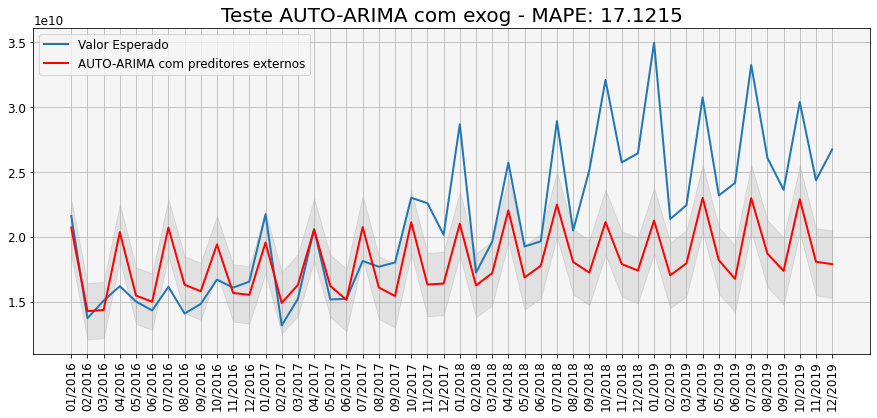

In [28]:
# Inverte a transformação operada no dataset sobre os valores da serie de teste e dos valores previstos, 
# para que fiquem na faixa real de valores de arrecadação


test_inv = scaler_in.inverse_transform(pd.DataFrame(test))
yhat_inv = scaler_in.inverse_transform(pd.DataFrame(yhat))


df_data = (pd.to_datetime(pd.DataFrame(test).index))

#Plota o resultado do modelo
fig, ax = plt.subplots()


ax.plot(test_inv, label='Valor Esperado')
ax.plot(yhat_inv, color='red', label='AUTO-ARIMA com preditores externos')
plt.fill_between(test.index, conf_int_inv[:,0], conf_int_inv[:,1], color='k', alpha=.08)
plt.title('Teste AUTO-ARIMA com exog - MAPE: %.4f' % calculo_mape(yhat_inv, test_inv))
plt.grid(True)
plt.xticks(ax.get_xticks(),df_data.strftime('%m/%Y'), rotation='vertical')
plt.legend(loc='upper left')


In [29]:
## Formatação das tabelas

pd.set_option('max_columns', None)
pd.options.display.float_format = '{:,.2%}'.format

In [30]:
variacao_percentual = pd.DataFrame(((test_inv/yhat_inv)-1), columns=['variacao'])

In [31]:
set_alerta_negativo = pd.DataFrame()
set_normal= pd.DataFrame()
set_alerta_positivo = pd.DataFrame()

In [32]:
for i in range (len(variacao_percentual)):
    if variacao_percentual.iloc[i].values[0] > 0.05:
        set_alerta_positivo = set_alerta_positivo.append(variacao_percentual[i:i+1])
    elif variacao_percentual.iloc[i].values[0] < -0.05:
        set_alerta_negativo = set_alerta_negativo.append(variacao_percentual[i:i+1])
    else:
        set_normal = set_normal.append(variacao_percentual[i:i+1])
        
        

In [33]:
set_alerta_negativo

,variacao
3,-20.43%
6,-22.00%
7,-13.56%
8,-6.18%
9,-13.95%
13,-11.60%
14,-6.56%
16,-6.41%
18,-12.57%


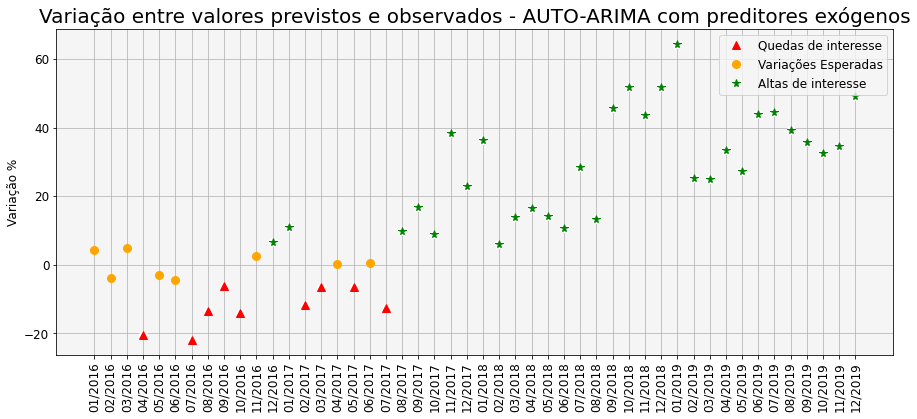

In [34]:
df_data = (pd.to_datetime(pd.DataFrame(test).index))

#Plota o resultado do modelo
fig, ax = plt.subplots()

ax.set_ylabel('Variação %')

plt.plot(variacao_percentual * 100, 'o', color='white')

if len(set_alerta_negativo) > 0:
    plt.plot(set_alerta_negativo * 100, 'g^', 
             color='red',  label='Quedas de interesse')

if len(set_normal) > 0:
    plt.plot(set_normal * 100, 'o', color='orange',  label='Variações Esperadas')

if len(set_alerta_positivo) > 0:
    plt.plot(set_alerta_positivo * 100, '*', color='green',  label='Altas de interesse')

plt.title('Variação entre valores previstos e observados - AUTO-ARIMA com preditores exógenos' )
plt.grid(True)
ax.set_xticks(range(0,48))
plt.xticks(ax.get_xticks(),df_data.strftime('%m/%Y'), rotation='vertical')
plt.legend(loc='upper right')


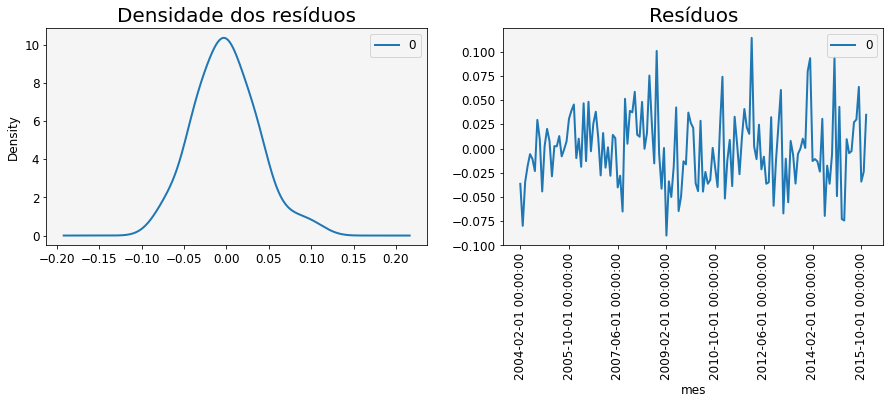

In [35]:
#Plotagem dos resíduos e densidade dos resíduos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
residuals = pd.DataFrame(cluster2_aarima.resid())
residuals.plot(ax=ax2, title='Resíduos', label=None)
residuals.plot(ax=ax1,kind='kde', title='Densidade dos resíduos')
plt.xticks(rotation='vertical')
plt.show()

[]

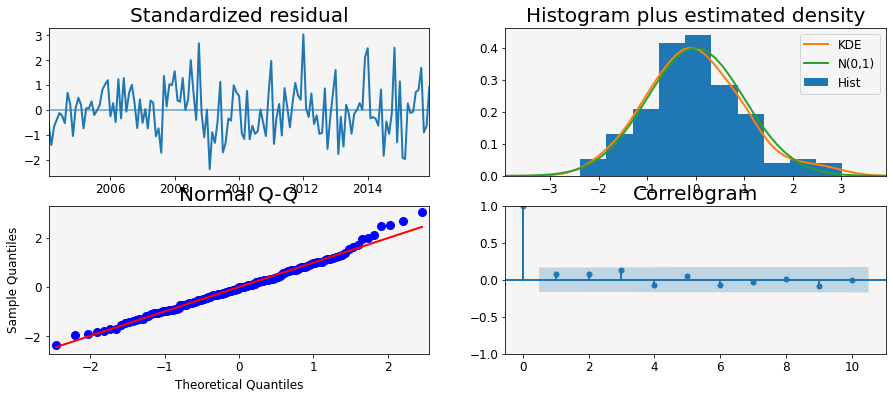

In [36]:
#Plota o diagnóstico do modelo 
cluster2_aarima.plot_diagnostics()
plt.plot()

## 2.3 Validando a predição

In [37]:
if type(validacao_cluster2['arrecadacao']) == 'pandas.core.series.Series':
    validacao_cluster2 = pd.Series(validacao_cluster2['arrecadacao'].values, index=validacao_cluster2.index)
    
validacao_cluster2.head()

,arrecadacao
mes,
2020-01-01 00:00:00,100.00%
2020-02-01 00:00:00,42.53%
2020-03-01 00:00:00,30.14%
2020-04-01 00:00:00,33.66%
2020-05-01 00:00:00,3.47%


In [38]:
#Faz a previsão no mesmo tamanho que a base de teste
yhat = cluster2_aarima.predict(n_periods=len(validacao_cluster2), X = validacao_cluster2_exog)
yhat = pd.Series(yhat, index = validacao_cluster2.index)
#Obtém o intervalo de confiança 
conf_int = cluster2_aarima.predict(len(validacao_cluster2), return_conf_int=True, alpha = 0.05, X = validacao_cluster2_exog) 

In [39]:
# Inverte a transformação operada no dataset sobre os valores do intervalo de confiança, 
# para que fiquem na faixa real de valores de arrecadação

conf_int_inv = scaler_valid.inverse_transform(pd.DataFrame(conf_int[1]))


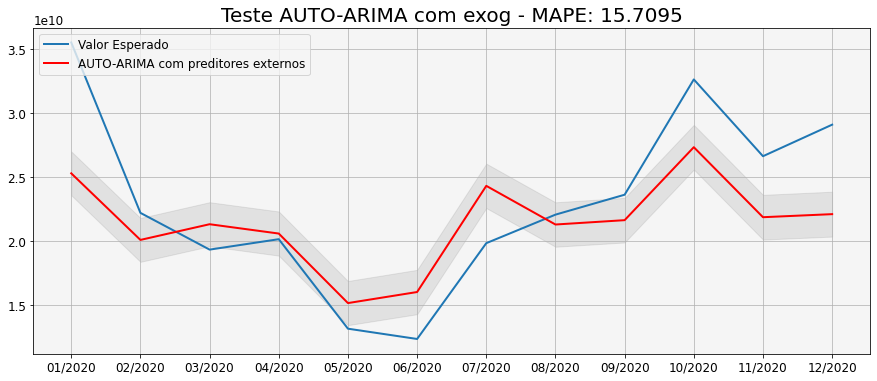

In [40]:
# Inverte a transformação operada no dataset sobre os valores da serie de validacao e dos valores previstos, 
# para que fiquem na faixa real de valores de arrecadação

valid_inv = scaler_valid.inverse_transform(pd.DataFrame(validacao_cluster2))
yhat_inv = scaler_valid.inverse_transform(pd.DataFrame(yhat))


df_data = (pd.to_datetime(pd.DataFrame(validacao_cluster2).index))

#Plota o resultado do modelo
fig, ax = plt.subplots()


ax.plot(valid_inv, label='Valor Esperado')
ax.plot(yhat_inv, color='red', label='AUTO-ARIMA com preditores externos')
plt.fill_between(validacao_cluster2.index, conf_int_inv[:,0], conf_int_inv[:,1], color='k', alpha=.08)
plt.title('Teste AUTO-ARIMA com exog - MAPE: %.4f' % calculo_mape(yhat_inv,valid_inv))
plt.grid(True)
plt.xticks(ax.get_xticks(),df_data.strftime('%m/%Y'), rotation='horizontal')
plt.legend(loc='upper left')



In [41]:
## Formatação das tabelas

pd.set_option('max_columns', None)
pd.options.display.float_format = '{:,.2%}'.format

In [42]:
variacao_percentual_pred = pd.DataFrame(((valid_inv/yhat_inv)-1), columns=['variacao'])

In [43]:
set_alerta_negativo = pd.DataFrame()
set_normal= pd.DataFrame()
set_alerta_positivo = pd.DataFrame()



In [44]:
for i in range (len(variacao_percentual_pred)):
    if variacao_percentual_pred.iloc[i].values[0] > 0.05:
        set_alerta_positivo = set_alerta_positivo.append(variacao_percentual_pred[i:i+1])
    elif variacao_percentual_pred.iloc[i].values[0] < -0.05:
        set_alerta_negativo = set_alerta_negativo.append(variacao_percentual_pred[i:i+1])
    else:
        set_normal = set_normal.append(variacao_percentual_pred[i:i+1])

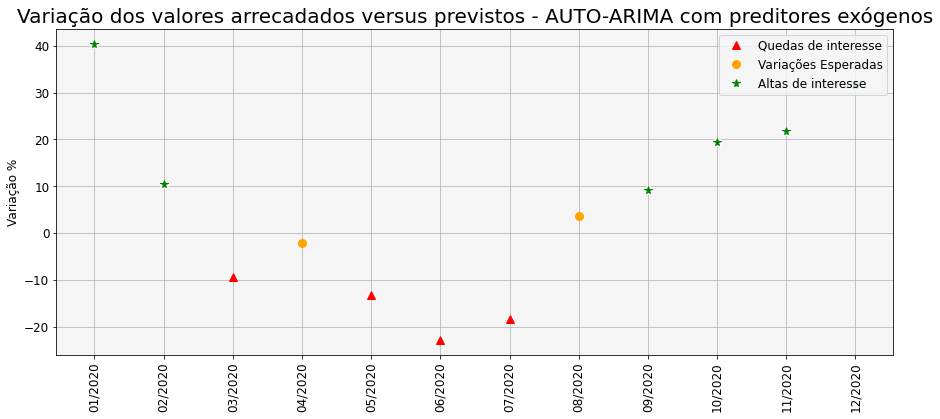

In [47]:
df_data = (pd.to_datetime(pd.DataFrame(validacao_cluster2).index))

#Plota o resultado do modelo
fig, ax = plt.subplots()

ax.set_ylabel('Variação %')

plt.plot(variacao_percentual_pred * 100, 'o', color='white')

if len(set_alerta_negativo) > 0:
    plt.plot(set_alerta_negativo * 100, 'g^', 
             color='red',  label='Quedas de interesse')

if len(set_normal) > 0:
    plt.plot(set_normal * 100, 'o', color='orange',  label='Variações Esperadas')

if len(set_alerta_positivo) > 0:
    plt.plot(set_alerta_positivo * 100, '*', color='green',  label='Altas de interesse')

    plt.title('Variação dos valores arrecadados versus previstos - AUTO-ARIMA com preditores exógenos' )
plt.grid(True)
ax.set_xticks(range(0,12))
plt.xticks(ax.get_xticks(),df_data.strftime('%m/%Y'), rotation='vertical')


plt.legend(loc='upper right')

In [46]:
type(variacao_percentual)

pandas.core.frame.DataFrame